In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.nn import functional as F
from matplotlib import pyplot as plt
import numpy as np

# Set the random seed for reproducibility
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available


In [2]:
# Define transformations for the training and test data
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load the CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


100%|██████████| 170498071/170498071 [00:03<00:00, 45227366.78it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Feature batch shape: torch.Size([64, 3, 32, 32])
Labels batch shape: torch.Size([64])


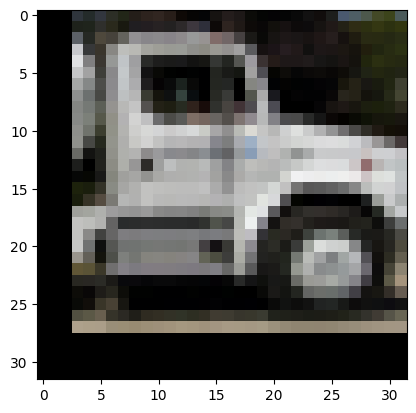

Label: truck


In [4]:
labels = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
std = [0.2023, 0.1994, 0.2010]
mean = [0.4914, 0.4822, 0.4465]
plt.imshow(((train_features[0].permute(1, 2, 0) * np.array(std) + np.array(mean))).numpy())
plt.show()
print(f"Label: {labels[train_labels[0]]}")

In [5]:
def conv3x3(in_planes, out_planes, stride=1):
  """3x3 convolution with padding"""
  return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                   padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
  """1x1 convolution"""
  return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


In [6]:
class Block(nn.Module):

  def __init__(self, inplanes, planes, stride=1, downsample=None):
    super(Block, self).__init__()
    self.conv1 = conv1x1(inplanes, planes, stride)
    self.bn1 = nn.BatchNorm2d(planes)
    self.relu = nn.ReLU(inplace=True)
    self.conv2 = conv3x3(planes, planes)
    self.bn2 = nn.BatchNorm2d(planes)
    self.downsample = downsample
    self.stride = stride

  def forward(self, x):
    residual = x
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)
    out = self.conv2(out)
    out = self.bn2(out)

    if self.downsample is not None:
      residual = self.downsample(x)
    out += residual
    out = self.relu(out)
    return out


In [7]:
class ResNet(nn.Module):

  def __init__(self, n_group=1):
    super(ResNet, self).__init__()
    self.n_group = n_group

    in_channels = 3
    self.layer0 = nn.Sequential(
        nn.Conv2d(in_channels, 32, kernel_size=(3, 3), stride=1, padding=1, bias=False),
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True))

    self.inplanes = 32
    self.layer1 = self._make_layer(32,  3, [2, 2]) # [16, 16]
    self.layer2 = self._make_layer(64,  4, [2, 2]) # [8, 8]
    self.layer3 = self._make_layer(128, 6, [2, 2]) # [4, 4]
    self.layer4 = self._make_layer(256, 6, [2, 2]) # [2, 2]
    self.layer5 = self._make_layer(512, 3, [2, 2]) # [1, 1]

    self.out_planes = 512

  def _make_layer(self, planes, blocks, stride):
    downsample = None
    if stride != [1, 1] or self.inplanes != planes:
      downsample = nn.Sequential(
          conv1x1(self.inplanes, planes, stride),
          nn.BatchNorm2d(planes))

    layers = []
    layers.append(Block(self.inplanes, planes, stride, downsample))
    self.inplanes = planes
    for _ in range(1, blocks):
      layers.append(Block(self.inplanes, planes))
    return nn.Sequential(*layers)

  def forward(self, x):
    x0 = self.layer0(x)
    x1 = self.layer1(x0)
    x2 = self.layer2(x1)
    x3 = self.layer3(x2)
    x4 = self.layer4(x3)
    x5 = self.layer5(x4)

    cnn_feat = x5.squeeze(2) # [N, c, w]
    cnn_feat = cnn_feat.transpose(2, 1)
    return cnn_feat

In [ ]:
resnet = ResNet()
resnet.to(device)

ResNet(
  (layer0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(32, 32, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Block(
      (conv1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(

In [ ]:
x = resnet(train_features.to(device))
print(x.shape)

torch.Size([64, 1, 512])


In [8]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool(F.relu(self.batch_norm2(self.conv2(x))))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [9]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

    return test_loss / len(test_loader)

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    losses = []
    test_losses = []
    model.train()
    num_iter = 0
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            num_iter += 1
            if num_iter % 100 == 0:  # Print loss every 100 iterations
                print(f'Epoch [{epoch+1}/{num_epochs}], Iteration [{num_iter}/{len(train_loader)}], Loss: {running_loss/100:.4f}')
                running_loss = 0.0
        num_iter = 0
        losses.append(running_loss / len(train_loader))
        test_loss = evaluate_model(model, test_loader, criterion)
        test_losses.append(test_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')
        print(f'Test Loss: {test_loss:.4f}')
    return losses, test_losses


In [10]:
# Initialize the model, loss function, and optimizer
model = CNN()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
# Training the model
num_epochs = 20
losses, test_losses = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs)

# Evaluating the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the 10,000 test images: {100 * correct / total:.2f}%')


Epoch [1/20], Iteration [100/782], Loss: 1.9455
Epoch [1/20], Iteration [200/782], Loss: 1.6173
Epoch [1/20], Iteration [300/782], Loss: 1.4984
Epoch [1/20], Iteration [400/782], Loss: 1.4403
Epoch [1/20], Iteration [500/782], Loss: 1.3790
Epoch [1/20], Iteration [600/782], Loss: 1.3290
Epoch [1/20], Iteration [700/782], Loss: 1.2941
Epoch [1/20], Loss: 0.1332
Test Loss: 1.2874
Epoch [2/20], Iteration [100/782], Loss: 1.2702
Epoch [2/20], Iteration [200/782], Loss: 1.1903
Epoch [2/20], Iteration [300/782], Loss: 1.1627
Epoch [2/20], Iteration [400/782], Loss: 1.1264
Epoch [2/20], Iteration [500/782], Loss: 1.1272
Epoch [2/20], Iteration [600/782], Loss: 1.1058
Epoch [2/20], Iteration [700/782], Loss: 1.0855
Epoch [2/20], Loss: 0.1104
Test Loss: 1.0848
Epoch [3/20], Iteration [100/782], Loss: 1.0493
Epoch [3/20], Iteration [200/782], Loss: 1.0258
Epoch [3/20], Iteration [300/782], Loss: 1.0304
Epoch [3/20], Iteration [400/782], Loss: 1.0258
Epoch [3/20], Iteration [500/782], Loss: 1.004

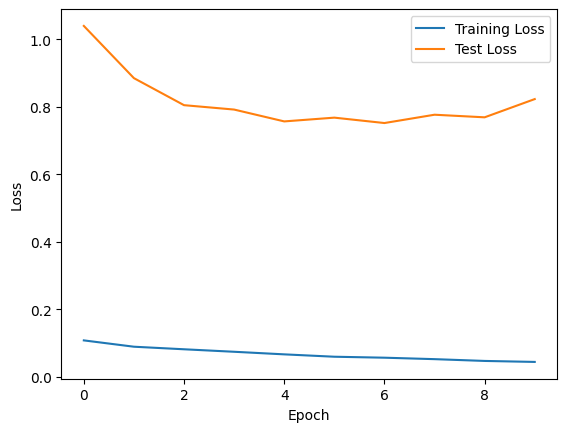

In [ ]:
plt.plot(losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

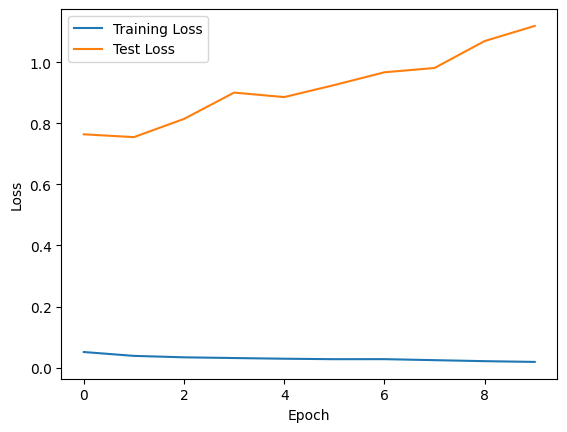

In [ ]:
plt.plot(losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

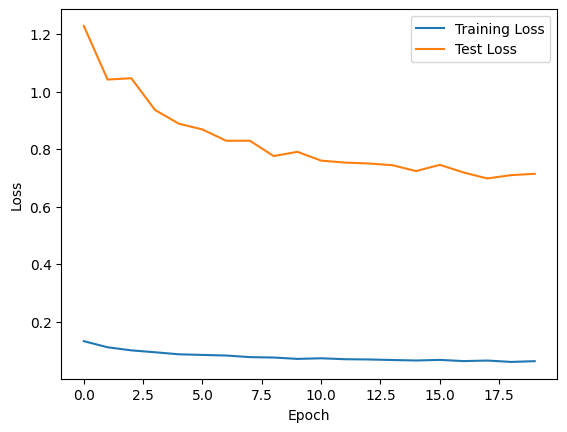

In [ ]:
plt.plot(losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

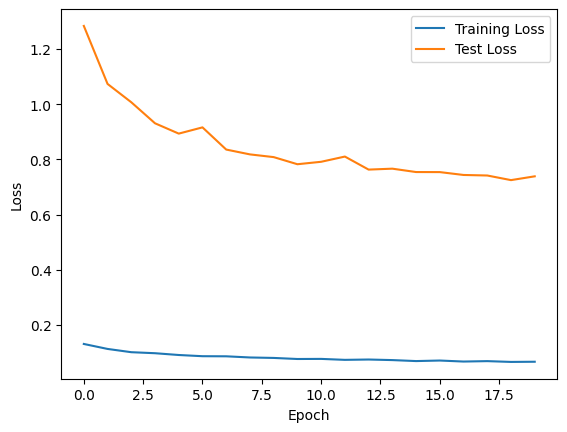

In [ ]:
plt.plot(losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()